In [1]:
import sys
sys.path.append("../../src")
import os
import numpy as np
import pickle
from autoencoder import full_network
from training import create_feed_dictionary, create_feed_dictionary2
from sindy_utils import *

import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from time import time
import seaborn as sns
%matplotlib inline
from copy import deepcopy
import matplotlib.patches as patches
import subprocess as sp
from error_utils import residual_2Dburger
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FormatStrFormatter

def get_cmap(n, name='tab20'):
    return plt.cm.get_cmap(name, n)
cmap = get_cmap(10)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def get_gpu_memory():
  _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]

  ACCEPTABLE_AVAILABLE_MEMORY = 1024
  COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
  memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
  memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
  return memory_free_values

device_list = tf.config.list_physical_devices('GPU')
free_mem = get_gpu_memory()
for i,gpu in enumerate(device_list):
    print(f'{gpu}: free memory: {free_mem[i]}')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): free memory: 16149
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'): free memory: 16149
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'): free memory: 16149
PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'): free memory: 16149


In [3]:
# specify which GPU to use
config = tf.ConfigProto(log_device_placement=False, gpu_options=tf.GPUOptions(allow_growth=True,visible_device_list='1'))

In [4]:
data_path = os.getcwd() + '/fig/nCase441_k1_MRN_nt200_ld3_p1_lr1e-4_width100_lamb1_1_1e-2_upEp2e4_subsize50_tend1/'

# params_results = pickle.load(open(data_path + 'experiment_results_2021_09_05_02_36.pkl', 'rb'))
save_name = 'burger_2022_02_28_23_54_25'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name
activation = params['activation']
lamb1 = params['loss_weight_sindy_x']
lamb2 = params['loss_weight_sindy_z']
lamb3 = params['loss_weight_sindy_regularization']
scaled = False
if scaled:
    if option == 1:
        u_sim = scaler_x.inverse_transform(u_sim)
        u_decoder = scaler_x.inverse_transform(u_decoder)
        du_sindy = scaler_dx.inverse_transform(du_sindy)
    elif option == 2:
        u_sim = u_sim * x_max
        u_decoder = u_decoder * x_max
        du_sindy = du_sindy * dx_max
    elif option == 3:
        u_sim = u_sim * x_scale + x_ref
        u_decoder = u_decoder * x_scale + x_ref
        du_sindy = du_sindy * dx_scale + dx_ref
params['coeff_exist'] = False
params['config'] = config

autoencoder_network = full_network(params)
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)

In [5]:
print(params['convex_knn'], params['num_test'], params['tol2'], 
      params['update_epoch'], params['max_epochs'], params['subsize_max'])

1 441 5 20000 1327007 50


In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def silu(x):
    return x * sigmoid(x)

def NN(x, weights, biases, activation):
    """
    this networks serve as either an encoder or a decoder.
    """
    num_layers = len(weights)
    for i in range(num_layers-1):
        x = np.matmul(x, weights[i]) + biases[i]
        if activation == 'tanh':
            x = np.tanh(x)
        elif activation == 'sigmoid':
            x = sigmoid(x)
            
    # output layer (linear activation)
    x = np.matmul(x, weights[-1]) + biases[-1]
    return x

def derivative(x):
    dxdt = np.empty(x.shape)
    D = D_Lele(x.shape[0], tstop/x.shape[0])   
    for i in range(x.shape[1]):
        dxdt[:,i] = np.dot(D.toarray(), x[:,i])
    del D
    return dxdt

In [9]:
def eval_perf(test_data, params, test_param, idx=None, knn=4, calc_dz=False):  
    timer = []
    
    # Step 1: set up tf graph and load parameters, can be optimized, excluded from ROM computational time
    timer.append(time()) 
    include_sine = False
    include_cosine = False
    if 'include_sine' in params.keys():
        include_sine = params['include_sine']
    if 'include_cosine' in params.keys():
        include_cosine = params['include_cosine']
        
#     sind_coeff_all = params['model_params'][0] # coefficients of all local SINDys
    z_encoder = NN(test_data['x'], params['model_params'][1], params['model_params'][2], activation) # encoder
    u_decoder = NN(z_encoder, params['model_params'][3], params['model_params'][4], activation) # decoder
    
    
    # Step 2: find the nearest neighbor (optional)
    timer.append(time()) 
    if idx == None:
        train_param = np.stack(params['param'])
        idx = np.argmin(np.linalg.norm(train_param-test_param, axis=1))
    
    
    # Step 3: calculate SINDy coefficients
    timer.append(time())        
    if knn == 1:
        print(f"Index of the nearest local SINDy: {idx+1}")
        sindy_coeff = params['model_params'][0][idx]
        
    else: # KNN convex interpolation of coefficients
        dist = np.linalg.norm(train_param-test_param, axis=1)
        knn_idx = np.argsort(dist)[:knn]
        phi = np.zeros_like(knn_idx)
        if dist[knn_idx[0]] == 0: # check if the min distance is zero
            phi[0] = 1
        else:
            phi = 1 / np.linalg.norm(train_param[knn_idx]-test_param, axis=1)**2
        psi = phi / phi.sum()
#         print("Weighted Convex interpolation of local SINDys: ", psi)

        sindy_coeff = np.zeros(params['model_params'][0][0].shape)
        for i,kidx in enumerate(knn_idx):
            sindy_coeff += psi[i] * params['model_params'][0][kidx]
            

    # Step 4: lastent-space dynamics prediction and obtain physical dynamics
    timer.append(time())
    z_sim = sindy_simulate(z_encoder[0,:], test_data['t'].squeeze(), 
                           sindy_coeff, params['poly_order'], 
                           include_sine,include_cosine)
    u_sim = NN(z_sim, params['model_params'][3], params['model_params'][4], activation)

    timer.append(time())
    
    if calc_dz:
        dz_encoder = derivative(z_encoder)
        dz_sim = derivative(z_sim)
    else:
        dz_encoder = 0
        dz_sim = 0
    
#     du_sindy = test_set_results['dx_decode'][:,idx,:]
#     dz_encoder = test_set_results['dz'][:,idx,:]
#     dz_sindy = test_set_results['dz_predict'][:,idx,:]
    
    
    timer1 = np.array(timer)
    timer2 = timer1[1:]
    timer_rom = timer2 - timer1[:-1]

    return u_decoder, u_sim, z_encoder, z_sim, dz_encoder, dz_sim, idx, timer_rom


### Interpolative prediction

In [10]:
def process_data(data, vel, nt, scaled, option=None):
    # select component
    if vel == 1:
        data['data'][0]['x'] = data['data'][0].pop('u')
        data['data'][0]['dx'] = data['data'][0].pop('du')
        data['data'][0].pop('v')
        data['data'][0].pop('dv')
    elif vel == 2:
        data['data'][0]['x'] = data['data'][0].pop('v')
        data['data'][0]['dx'] = data['data'][0].pop('dv')
        data['data'][0].pop('u')
        data['data'][0].pop('du')
    elif vel == 3:
        data['data'][0]['x'] = np.hstack((data['data'][0]['u'], data['data'][0]['v']))
        data['data'][0]['dx'] = np.hstack((data['data'][0]['du'], data['data'][0]['dv']))
        
    # select time steps
    data['data'][0]['x'] = data['data'][0]['x'][:nt+1]
    data['data'][0]['dx'] = data['data'][0]['dx'][:nt+1]
    data_x = np.copy(data['data'][0]['x'])
    data_dx = np.copy(data['data'][0]['dx'])

    # normalize data
    if scaled:
        if option == 1:
            data['data'][0]['x'] = data.transform(test_data['data'][0]['x'])
            data['data'][0]['dx'] = data.transform(test_data['data'][0]['dx'])
        elif option == 2:
            print(x_max, dx_max)
            data['data'][0]['x'] = data['data'][0]['x'] / x_max
            data['data'][0]['dx'] = data['data'][0]['dx'] / dx_max
        elif option == 3:
            data['data'][0]['x'] = (data['data'][0]['x']-x_ref) / x_scale
            data['data'][0]['dx'] = (data['data'][0]['dx']-dx_ref) / dx_scale
    return data, data_x, data_dx

In [11]:
Re = params['pde']['Re']
nx = params['pde']['nx']
ny = nx
nt = params['pde']['nt']
tstop = params['pde']['tstop']
t_test = tstop
vel = 3
knn = 1
amp_arr = np.array([0.7])
width_arr = np.array([0.9])
test_data = pickle.load(open(f"./data/local1_Re{Re}_A{amp_arr[0]:.2f}_W{width_arr[0]:.2f}_tstop{tstop:.1f}_nt{nt}_nx{nx}.p", "rb"))

ic = params['pde']['ic']

In [12]:
nt_test = int(t_test/tstop*nt)
t = np.linspace(0,t_test,nt_test+1)
if scaled:
    test_data, test_data_x, test_data_dx = process_data(test_data, vel, nt_test, scaled, option=option)
else:
    test_data, test_data_x, test_data_dx = process_data(test_data, vel, nt_test, scaled, option=None)

u_decoder, u_sim, z_encoder, z_sim, dz_encoder, dz_sindy, idx, timer_rom = eval_perf(test_data['data'][0], params, 
                                                                                     test_data['param'][0], knn=knn, 
                                                                                     calc_dz=True)
time_rom = timer_rom[1:].sum()

# print(u_decoder.shape, du_sindy.shape, u_sim.shape, z_encoder.shape, z_sim.shape, dz_encoder.shape, dz_sindy.shape)
print(f'time: {time_rom:.2f} s')

Index of the nearest local SINDy: 1
time: 0.01 s


In [13]:
# MSE of all time steps
err_decoder = np.linalg.norm(test_data_x - u_decoder, axis=1) / np.linalg.norm(test_data_x, axis=1)*100
err_sindy = np.linalg.norm(test_data_x - u_sim, axis=1) / np.linalg.norm(test_data_x, axis=1)*100
print(f'max autoencoder error: {err_decoder.max():.2f} %')
print(f'max sindy-decoder error: {err_sindy.max():.2f} %')

max autoencoder error: 0.88 %
max sindy-decoder error: 1.28 %


In [14]:
print(f'z norm: {np.linalg.norm(z_sim-z_encoder):.8f}')
# print(f'dz norm: {np.linalg.norm(dz_sindy-dz_encoder):.8f}')
print(f'x norm: {np.linalg.norm(u_sim-u_decoder):.8f}')
# print(f'dx norm: {np.linalg.norm(du_sindy-test_data_dx):.8f}')

z norm: 1.09642746
x norm: 0.75112816


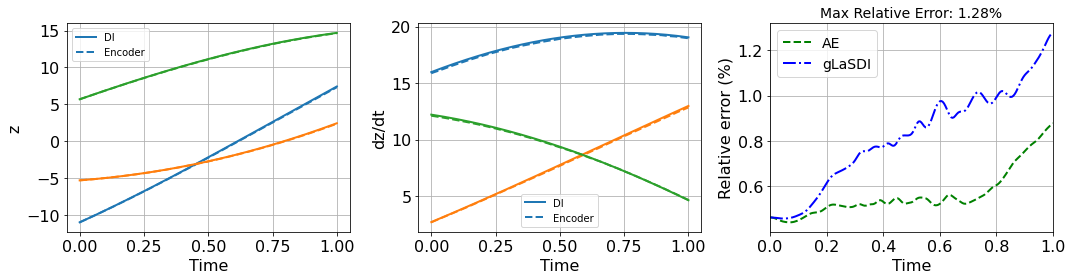

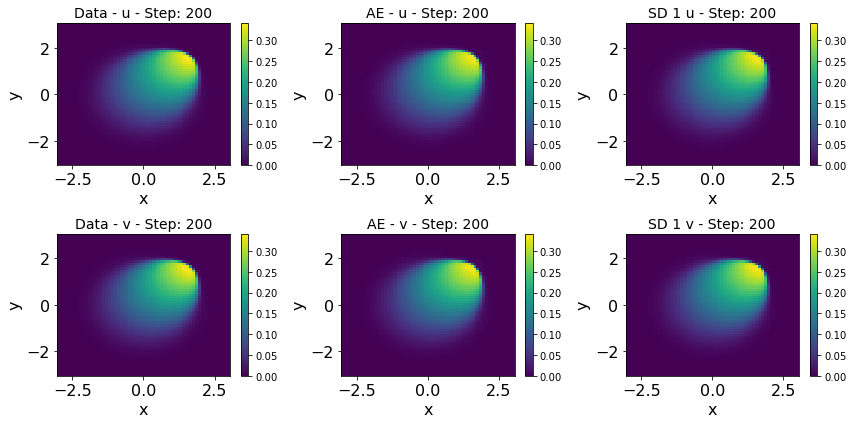

In [15]:
[xv,yv] = np.meshgrid(np.linspace(-3,3,nx),np.linspace(-3,3,ny),indexing='xy')
step = int(nt_test/1)
# step = 0
vmin_x = 0
vmax_x = test_data_x[step,:].max()
vmin_dx = 0
vmax_dx = test_data_dx[step,:].max()/2

fig1 = plt.figure(figsize=(15,4))
ax = fig1.add_subplot(131)
for i in range(z_sim.shape[1]):
    ax.plot(t, z_sim[:,i], '-', linewidth=2, c=cmap(i))
    ax.plot(t, z_encoder[:,i], '--', linewidth=2, c=cmap(i))
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('z', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.legend(['DI', 'Encoder'])
ax.grid()
# ax.set_title('DI predicted latent dynamics', fontsize=14)

ax = fig1.add_subplot(132)
for i in range(z_sim.shape[1]):
    ax.plot(t, dz_sindy[:,i], '-', linewidth=2, c=cmap(i))
    ax.plot(t, dz_encoder[:,i], '--', linewidth=2, c=cmap(i))
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('dz/dt', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.legend(['DI', 'Encoder'])
ax.grid()
# ax.set_title('DI predicted latent dynamics', fontsize=14)

ax = fig1.add_subplot(133)
ax.plot(t, err_decoder, 'g--', linewidth=2, label='AE')
ax.plot(t, err_sindy, 'b-.', linewidth=2, label='gLaSDI')
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Relative error (%)', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.grid()
ax.set_xlim(0,t_test)
ax.set_title(f'Max Relative Error: {err_sindy.max():.2f}%', fontsize=14)
ax.legend(fontsize=14, loc='upper left')

plt.tight_layout()
plt.savefig(data_path + f"latent_dynamics_{lamb1:.1e}_{lamb2:.1e}_{lamb3:.1e}_A{amp_arr[0]:.2f}_W{width_arr[0]:.2f}.png")

fig1 = plt.figure(figsize=(12,6))
ax = fig1.add_subplot(231)
p_u = ax.pcolor(xv, yv, test_data_x[step,:nx*ny].reshape(ny,nx), shading='auto', vmin=vmin_x, vmax=vmax_x)
cb_u = fig1.colorbar(p_u, ax=ax)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_title(f'Data - u - Step: {step}', fontsize=14)

ax = fig1.add_subplot(232)
p_u = ax.pcolor(xv, yv, u_decoder[step,:nx*ny].reshape(ny,nx), shading='auto', vmin=vmin_x, vmax=vmax_x)
cb_u = fig1.colorbar(p_u, ax=ax)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_title(f'AE - u - Step: {step}', fontsize=14)

ax = fig1.add_subplot(233)
p_u = ax.pcolor(xv, yv, u_sim[step,:nx*ny].reshape(ny,nx), shading='auto', vmin=vmin_x, vmax=vmax_x)
cb_u = fig1.colorbar(p_u, ax=ax)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_title(f'SD {idx+1} u - Step: {step}', fontsize=14)

ax = fig1.add_subplot(234)
p_u = ax.pcolor(xv, yv, test_data_x[step,nx*ny:].reshape(ny,nx), shading='auto', vmin=vmin_x, vmax=vmax_x)
cb_u = fig1.colorbar(p_u, ax=ax)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_title(f'Data - v - Step: {step}', fontsize=14)

ax = fig1.add_subplot(235)
p_u = ax.pcolor(xv, yv, u_decoder[step,nx*ny:].reshape(ny,nx), shading='auto', vmin=vmin_x, vmax=vmax_x)
cb_u = fig1.colorbar(p_u, ax=ax)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_title(f'AE - v - Step: {step}', fontsize=14)

ax = fig1.add_subplot(236)
p_u = ax.pcolor(xv, yv, u_sim[step,nx*ny:].reshape(ny,nx), shading='auto', vmin=vmin_x, vmax=vmax_x)
cb_u = fig1.colorbar(p_u, ax=ax)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_title(f'SD {idx+1} v - Step: {step}', fontsize=14)

plt.tight_layout()
plt.savefig(data_path + f"inter_pred_{lamb1:.1e}_{lamb2:.1e}_{lamb3:.1e}_A{amp_arr[0]:.2f}_W{width_arr[0]:.2f}.png")

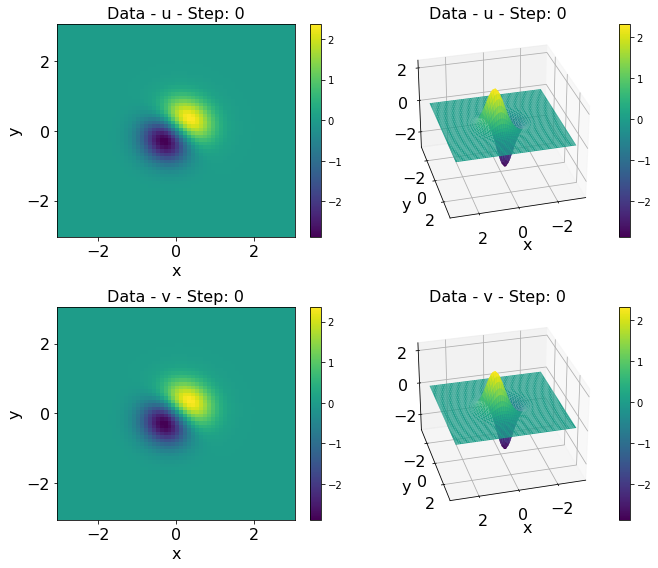

In [16]:
step = 0

fig1 = plt.figure(figsize=(18,8))
ax = fig1.add_subplot(241)
p_u = ax.pcolor(xv, yv, test_data_dx[step,:nx*ny].reshape(ny,nx), shading='auto')
cb_u = fig1.colorbar(p_u, ax=ax)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_title(f'Data - u - Step: {step}', fontsize=16)

# ax = fig1.add_subplot(243)
# p_u = ax.pcolor(xv, yv, du_sindy[step,:nx*ny].reshape(ny,nx), shading='auto')
# cb_u = fig1.colorbar(p_u, ax=ax)
# ax.set_xlabel('x', fontsize=16)
# ax.set_ylabel('y', fontsize=16)
# ax.tick_params(axis='both', labelsize=16)
# ax.set_title(f'AE - u - Step: {step}', fontsize=16)

ax = fig1.add_subplot(242, projection='3d')
p_u = ax.plot_surface(xv, yv, test_data_dx[step,:nx*ny].reshape(ny,nx), cmap=cm.viridis, rstride=1, cstride=1)
ax.view_init(elev=30,azim=75)
cb_u = fig1.colorbar(p_u,ax=ax)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_title(f'Data - u - Step: {step}', fontsize=16)

# ax = fig1.add_subplot(244, projection='3d')
# p_u = ax.plot_surface(xv, yv, du_sindy[step,:nx*ny].reshape(ny,nx), cmap=cm.viridis, rstride=1, cstride=1)
# ax.view_init(elev=30,azim=75)
# cb_u = fig1.colorbar(p_u,ax=ax)
# ax.set_xlabel('x', fontsize=16)
# ax.set_ylabel('y', fontsize=16)
# ax.tick_params(axis='both', labelsize=16)
# ax.set_title(f'AE - u - Step: {step}', fontsize=16)

ax = fig1.add_subplot(245)
p_u = ax.pcolor(xv, yv, test_data_dx[step,nx*ny:].reshape(ny,nx), shading='auto')
cb_u = fig1.colorbar(p_u, ax=ax)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_title(f'Data - v - Step: {step}', fontsize=16)

# ax = fig1.add_subplot(247)
# p_u = ax.pcolor(xv, yv, du_sindy[step,nx*ny:].reshape(ny,nx), shading='auto')
# cb_u = fig1.colorbar(p_u, ax=ax)
# ax.set_xlabel('x', fontsize=16)
# ax.set_ylabel('y', fontsize=16)
# ax.tick_params(axis='both', labelsize=16)
# ax.set_title(f'AE - v - Step: {step}', fontsize=16)

ax = fig1.add_subplot(246, projection='3d')
p_u = ax.plot_surface(xv, yv, test_data_dx[step,nx*ny:].reshape(ny,nx), cmap=cm.viridis, rstride=1, cstride=1)
ax.view_init(elev=30,azim=75)
cb_u = fig1.colorbar(p_u,ax=ax)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_title(f'Data - v - Step: {step}', fontsize=16)

# ax = fig1.add_subplot(248, projection='3d')
# p_u = ax.plot_surface(xv, yv, du_sindy[step,nx*ny:].reshape(ny,nx), cmap=cm.viridis, rstride=1, cstride=1)
# ax.view_init(elev=30,azim=75)
# cb_u = fig1.colorbar(p_u,ax=ax)
# ax.set_xlabel('x', fontsize=16)
# ax.set_ylabel('y', fontsize=16)
# ax.tick_params(axis='both', labelsize=16)
# ax.set_title(f'AE - v - Step: {step}', fontsize=16)

plt.tight_layout()

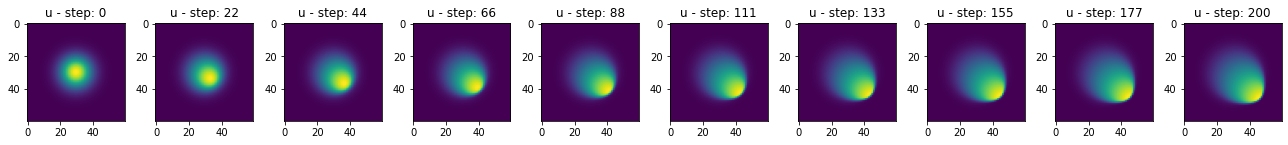

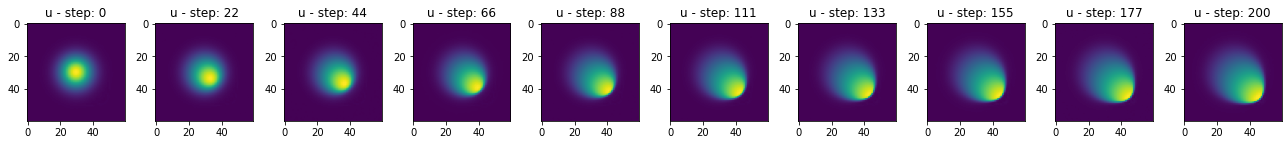

In [17]:
step_list = np.linspace(0,nt_test,10).astype(int)
fig = plt.figure(figsize=(18,3))
for i,step in enumerate(step_list):
    ax = fig.add_subplot(1,10,i+1)
    ax.imshow(test_data_x[step,:nx*ny].reshape(ny,nx))
    ax.set_title(f'u - step: {step}')
# plt.colorbar()
# plt.clim(test_data_x.min(), test_data_x.max())
plt.tight_layout()

fig = plt.figure(figsize=(18,3))
for i,step in enumerate(step_list):
    ax = fig.add_subplot(1,10,i+1)
    ax.imshow(u_sim[step,:nx*ny].reshape(ny,nx))
    ax.set_title(f'u - step: {step}')
# plt.colorbar()
# plt.clim(test_data_x.min(), test_data_x.max())
plt.tight_layout()
    
# fig = plt.figure(figsize=(18,3))
# for i,step in enumerate(step_list):
#     ax = fig.add_subplot(1,10,i+1)
#     ax.imshow(test_data_dx[step,:nx*ny].reshape(ny,nx))
#     ax.set_title(f'du/dt - step: {step}')
# # plt.colorbar()
# # plt.clim(test_data_dx.min(), test_data_dx.max())
# plt.tight_layout()
    
# fig = plt.figure(figsize=(18,3))
# for i,step in enumerate(step_list):
#     ax = fig.add_subplot(1,10,i+1)
#     ax.imshow(du_sindy[step,:nx*ny].reshape(ny,nx))
#     ax.set_title(f'du/dt - step: {step}')
# # plt.colorbar()
# # plt.clim(test_data_dx.min(), test_data_dx.max())
plt.tight_layout()

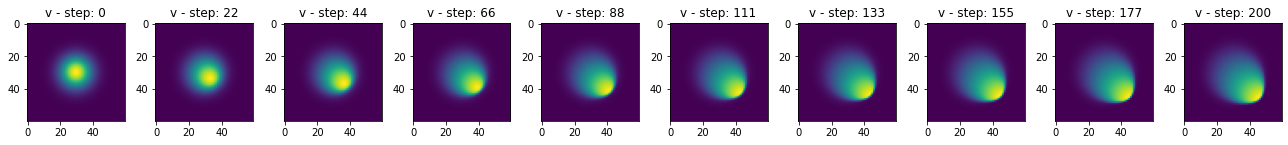

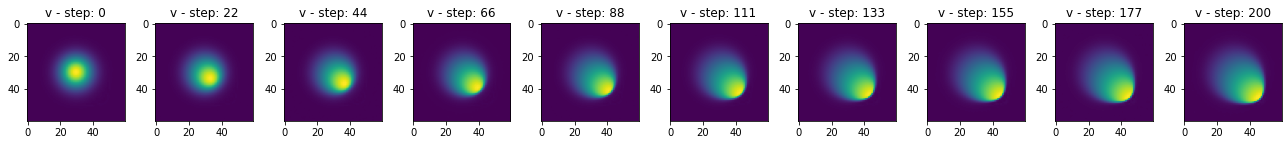

In [18]:
step_list = np.linspace(0,nt_test,10).astype(int)
fig = plt.figure(figsize=(18,3))
for i,step in enumerate(step_list):
    ax = fig.add_subplot(1,10,i+1)
    ax.imshow(test_data_x[step,nx*ny:].reshape(ny,nx))
    ax.set_title(f'v - step: {step}')
# plt.colorbar()
# plt.clim(test_data_x.min(), test_data_x.max())
plt.tight_layout()

fig = plt.figure(figsize=(18,3))
for i,step in enumerate(step_list):
    ax = fig.add_subplot(1,10,i+1)
    ax.imshow(u_sim[step,nx*ny:].reshape(ny,nx))
    ax.set_title(f'v - step: {step}')
# plt.colorbar()
# plt.clim(test_data_x.min(), test_data_x.max())
plt.tight_layout()
    
# fig = plt.figure(figsize=(18,3))
# for i,step in enumerate(step_list):
#     ax = fig.add_subplot(1,10,i+1)
#     ax.imshow(test_data_dx[step,nx*ny:].reshape(ny,nx))
#     ax.set_title(f'dv/dt - step: {step}')
# # plt.colorbar()
# # plt.clim(test_data_dx.min(), test_data_dx.max())
# plt.tight_layout()
    
# fig = plt.figure(figsize=(18,3))
# for i,step in enumerate(step_list):
#     ax = fig.add_subplot(1,10,i+1)
#     ax.imshow(du_sindy[step,nx*ny:].reshape(ny,nx))
#     ax.set_title(f'dv/dt - step: {step}')
# plt.colorbar()
# plt.clim(test_data_dx.min(), test_data_dx.max())
plt.tight_layout()

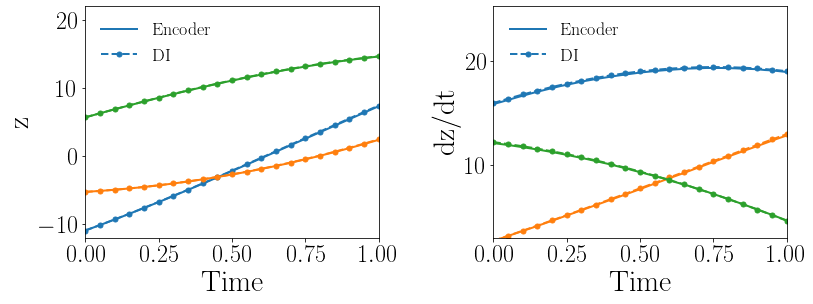

In [22]:
plt.rcParams.update({"font.size": 30,
                     "text.usetex": True,
                     "font.family": "Times New Roman"}) # fontsize for figures

fig1 = plt.figure(figsize=(12,5))
line_type = ['-','-*','-.','-^','-s']
idx = np.arange(0,t.size,10)
ax = fig1.add_subplot(121)
for i in range(z_encoder.shape[1]):
    ax.plot(t, z_encoder[:,i], '-', lw=2, c=cmap(i))
    ax.plot(t[idx], z_sim[idx,i], '--o', lw=2, markersize=5, c=cmap(i))
ax.set_xlabel('Time')
ax.set_ylabel('z')
ax.set_xticks(np.linspace(0,t.max(),5))
ax.set_ylim(z_sim.min()*1.1,z_sim.max()*1.5)
ax.tick_params(axis='both', labelsize=24)
ax.legend(['Encoder', 'DI'], loc='upper left', frameon=False, fontsize=18)
# ax.grid()
ax.set_xlim(t.min(),t.max())

ax = fig1.add_subplot(122)
for i in range(z_sim.shape[1]):
    ax.plot(t, dz_encoder[:,i], '-', linewidth=2, c=cmap(i))
    ax.plot(t[idx], dz_sindy[idx,i], '--o', linewidth=2, markersize=5, c=cmap(i))
ax.set_xlabel('Time')
ax.set_ylabel('dz/dt')
ax.set_xticks(np.linspace(0,t.max(),5))
ax.set_xlim(0,t.max())
ax.set_ylim(dz_sindy.min()*1.1,dz_sindy.max()*1.3)
ax.tick_params(axis='both', labelsize=24)
ax.legend(['Encoder', 'DI'], loc='upper left', frameon=False, fontsize=18)
# ax.grid()

plt.tight_layout()
plt.savefig(data_path + f"2Dburger_latent_dynamics.png",bbox_inches='tight')

### Extended domain

In [23]:
knn = 3
res_name = f'mean'
sindy_name = f'knn{knn}convex'

# Re = 10000
# nx = 60
# ny = nx
# nt = 200
# tstop = 2
# t_test = 2
nt_test = int(t_test/tstop*nt)
t = np.linspace(0,t_test,nt_test+1)
vel = 3 # 1: u, 2: v, 3: u and v

# amp_test = np.arange(0.7,0.9,0.05)
# width_test = np.arange(0.9,1.1,0.05)
amp_test = params['test_param'][:,0]
width_test = params['test_param'][:,1]
amp_size = amp_test.size
width_size = width_test.size
num_case = amp_size * width_size
max_err = np.zeros([amp_size, width_size])
mse_map = np.zeros([amp_size, width_size])
res_norm = np.zeros([amp_size, width_size])
sindy_idx = np.zeros([amp_size, width_size])
test_data_all = pickle.load(open(f"./data/local{num_case}_Re{Re}_tstop{tstop:.1f}_nt{nt}_nx{nx}.p", "rb"))
# test_data_all = pickle.load(open(f"./data/local{num_case}_Re{Re}_tstop{tstop:.1f}_nt{nt}_nx{nx}_norm.p", "rb"))

speed_up = 0
mse_all = 0
count = 0
timer_rom = np.zeros(4)
start_time = time()
for i,a in enumerate(amp_test):
    for j,w in enumerate(width_test):
        print(f'{count+1}/{num_case}:')
        test_data = {}
        test_data['data'] = [deepcopy(test_data_all['data'][count])]
        test_data['param'] = [deepcopy(test_data_all['param'][count])]
        
        if scaled:
            test_data, test_data_x,_ = process_data(test_data, vel, nt_test, scaled, option=option)
        else:
            test_data, test_data_x,_ = process_data(test_data, vel, nt_test, scaled, option=None)
            
        _,u_sim,_,_,_,_,idx,t_rom = eval_perf(test_data['data'][0], params, 
                                              test_data['param'][0], knn=knn,
                                             calc_dz=False)
        timer_rom += t_rom
        sindy_idx[i,j] = idx+1
        
        # MSE of all time steps
        mse = np.linalg.norm(test_data_x - u_sim)**2
        mse_map[i,j] = mse
        
        # max error of all time steps
        max_err[i,j] = (np.linalg.norm(test_data_x - u_sim, axis=1) \
                                        / np.linalg.norm(test_data_x, axis=1)*100).max()
        
        # residual norm
        params['pde']['param'] = [a, w]
        res = []
        for k in range(nt):
            res.append(residual_2Dburger(u_sim[k,:], u_sim[k+1,:], params))
        res_norm[i,j] = np.stack(res).mean()
        
        count += 1
end_time = time()
time_rom = timer_rom[1:].sum()/num_case # from Step 2 to 4
time_sim = 38.4 # seconds
speed_up = time_sim / time_rom
print(f'Time taken: {end_time-start_time:.2f} s, {(end_time-start_time)/60:.2f} mins')
print(f'Average MSE: {mse_map.sum() / num_case:.2f} %')
print(f'Average speed up: {speed_up:.2f}')
# for i,t in enumerate(timer_rom):
#     print(f'ROM time{i}: {t:.8f} s')

1/441:
2/441:
3/441:
4/441:
5/441:
6/441:
7/441:
8/441:
9/441:
10/441:
11/441:
12/441:
13/441:
14/441:
15/441:
16/441:
17/441:
18/441:
19/441:
20/441:
21/441:
22/441:
23/441:
24/441:
25/441:
26/441:
27/441:
28/441:
29/441:
30/441:
31/441:
32/441:
33/441:
34/441:
35/441:
36/441:
37/441:
38/441:
39/441:
40/441:
41/441:
42/441:
43/441:
44/441:
45/441:
46/441:
47/441:
48/441:
49/441:
50/441:
51/441:
52/441:
53/441:
54/441:
55/441:
56/441:
57/441:
58/441:
59/441:
60/441:
61/441:
62/441:
63/441:
64/441:
65/441:
66/441:
67/441:
68/441:
69/441:
70/441:
71/441:
72/441:
73/441:
74/441:
75/441:
76/441:
77/441:
78/441:
79/441:
80/441:
81/441:
82/441:
83/441:
84/441:
85/441:
86/441:
87/441:
88/441:
89/441:
90/441:
91/441:
92/441:
93/441:
94/441:
95/441:
96/441:
97/441:
98/441:
99/441:
100/441:
101/441:
102/441:
103/441:
104/441:
105/441:
106/441:
107/441:
108/441:
109/441:
110/441:
111/441:
112/441:
113/441:
114/441:
115/441:
116/441:
117/441:
118/441:
119/441:
120/441:
121/441:
122/441:
123/441:
1

In [24]:
a_grid, w_grid = np.meshgrid(amp_test, width_test)
param_list = np.hstack([a_grid.flatten().reshape(-1,1), w_grid.flatten().reshape(-1,1)])

a_grid, w_grid = np.meshgrid(np.arange(amp_test.size), np.arange(width_test.size))
idx_list = np.hstack([a_grid.flatten().reshape(-1,1), w_grid.flatten().reshape(-1,1)])

idx_param = []
for i,ip in enumerate(params['param']):
    idx = np.argmin(np.linalg.norm(param_list-ip, axis=1))
    idx_param.append((idx, np.array([param_list[idx,0], param_list[idx,1]])))

In [25]:
max_err_train = []
res_norm_train = []
for i in idx_param:
    idd = i[0]
    max_err_train.append(max_err[idx_list[idd,0],idx_list[idd,1]])
    res_norm_train.append(res_norm[idx_list[idd,0],idx_list[idd,1]])
max_err_train = np.stack(max_err_train)
res_norm_train = np.stack(res_norm_train)
err_ratio_train = res_norm_train / max_err_train
err_ratio_train_mean = err_ratio_train.mean()
res_norm_tol = err_ratio_train_mean * params['tol2']
print(f'tolerance of residual norm (mean): {res_norm_tol:.5f}')
print(f"tolerance of residual norm (reg_max): {params['tol']:.5f}")

tolerance of residual norm (mean): 0.02151
tolerance of residual norm (reg_max): 0.02921


In [26]:
# fig = plt.figure(figsize=(18,4))
# ax = fig.add_subplot(131)
# ax.plot(np.arange(1,res_norm.size+1), res_norm.flatten(), 'r.', label='res_norm_'+res_name)
# # ax.set_xlabel('Time Steps', fontsize=14)
# ax.set_ylabel('Errors', fontsize=14)
# ax.tick_params(labelsize=14)
# ax.grid()
# ax.legend(fontsize=14)

# ax = fig.add_subplot(132)
# ax.plot(np.arange(1,res_norm.size+1), max_err.flatten(), 'b.', label='maxRelErr')
# # ax.set_xlabel('Time Steps', fontsize=14)
# ax.set_ylabel('Errors', fontsize=14)
# ax.tick_params(labelsize=14)
# ax.grid()
# ax.legend(fontsize=14)

# ax = fig.add_subplot(133)
# x = max_err.flatten().reshape(-1,1)
# y = res_norm.flatten().reshape(-1,1)
# reg = LinearRegression().fit(x, y)
# y_pred = reg.predict(x)
# y_diff = y - y_pred
# x_test = np.linspace(0,max_err.max(),2).reshape(-1,1)
# y_test = reg.predict(x_test)
# y_test1 = reg.coef_ * x_test + reg.intercept_+ y_diff.min()
# y_test2 = reg.coef_ * x_test + reg.intercept_+ y_diff.max()
# y_test3 = reg.coef_ * params['tol2'] + reg.intercept_+ y_diff.max()
# ax.plot(max_err.flatten(), res_norm.flatten(), 'g.')
# ax.plot(x_test,y_test,'r-')
# ax.plot(x_test,y_test1,'r--')
# ax.plot(x_test,y_test2,'r--')

# x_test2 = np.linspace(0,params['tol2'],2).reshape(-1,1)
# y_test2 = err_ratio_train_mean * x_test2
# # ax.plot(x_test2,y_test2,'b-')
# # ax.plot([0,x_test2.max()],[res_norm_tol,res_norm_tol],'b--')
# ax.plot([x_test2.max(),x_test2.max()],[0,max(y_test3,res_norm_tol)],'k--')
# ax.plot(x_test2.max(),res_norm_tol,'b.',markersize=15, label='mean')
# ax.plot(params['tol2'],y_test3,'r.',markersize=15, label='reg')
# plt.legend(fontsize=16)

# # y_test3 = 0.5*(err_ratio_train_mean+reg.coef_[0][0]) * x_test2 + reg.intercept_[0]
# # res_norm_tol2 = 0.5*(err_ratio_train_mean+reg.coef_[0][0]) * params['tol2'] + reg.intercept_[0]
# # y_test3 = 0.5*(err_ratio_train_mean+reg.coef_[0][0]) * x_test2
# # res_norm_tol2 = 0.5*(err_ratio_train_mean+reg.coef_[0][0]) * params['tol2']
# # ax.plot(x_test2,y_test3,'k-')
# # ax.plot([0,x_test2.max()],[res_norm_tol2,res_norm_tol2],'k--')
# # ax.plot([x_test2.max(),x_test2.max()],[0,res_norm_tol2],'k--')
# # ax.plot(x_test2.max(),res_norm_tol2,'k.',markersize=15)

# ax.set_xlabel('$Max relative error (%)$', fontsize=16)
# ax.set_ylabel('Residual norm', fontsize=16)
# # ax.set_title('res_norm_'+res_name)
# ax.tick_params(labelsize=16)
# ax.grid()

# plt.tight_layout()
# plt.savefig(data_path + f'residual_norm_{res_name}_knn{knn}.png')
# print(max_err.max())

In [27]:
# # heat map of max relative errors
# sns.set(font_scale=1.3)
# def max_err_heatmap(max_err, sindy_idx, idx_list=[], idx_param=[], label='Max. Relative Error (%)', dtype='int', scale=1):
#     if dtype == 'int':
#         max_err = max_err.astype(int)
#         fmt1 = 'd'
#     else:
#         fmt1 = '.1f'
#     rect = []
# #     rect.append(patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
# #     rect.append(patches.Rectangle((amp_test.size-1, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
# #     rect.append(patches.Rectangle((amp_test.size-1, width_test.size-1), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
# #     rect.append(patches.Rectangle((0, width_test.size-1), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     for i in range(len(idx_param)):
#         print(f"idx: {idx_param[i][0]}, param: {idx_param[i][1]}")
#         idd = idx_param[i][0]
# #         rect.append(patches.Rectangle((idx_list[idd,0], idx_list[idd,1]), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#         rect.append(patches.Rectangle((idx_list[idd,1], idx_list[idd,0]), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     rect2 = deepcopy(rect)
    
#     if max_err.size < 100:
#         fig = plt.figure(figsize=(10,5))
#     else:
#         fig = plt.figure(figsize=(18,9))
    
#     # local SINDy indices
#     ax = fig.add_subplot(121)
#     sindy_idx = sindy_idx.astype(int)
#     sns.heatmap(sindy_idx, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
#                 annot=True, fmt='d', annot_kws={'size':14}, 
#                 cbar=False, cmap='Spectral', robust=True, vmin=1, vmax=len(idx_param)+5)
#     for i in rect:
#         ax.add_patch(i)
        
#     # format text labels
#     fmt = '{:0.2f}'
#     xticklabels = []
#     for item in ax.get_xticklabels():
#         item.set_text(fmt.format(float(item.get_text())))
#         xticklabels += [item]
#     yticklabels = []
#     for item in ax.get_yticklabels():
#         item.set_text(fmt.format(float(item.get_text())))
#         yticklabels += [item]
#     ax.set_xticklabels(xticklabels)
#     ax.set_yticklabels(yticklabels)
#     ax.set_xlabel('Width', fontsize=16)
#     ax.set_ylabel('Amplitude', fontsize=16)
#     ax.set_title('Index of Selected Local SINDy', fontsize=16)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=30) 

#     # heatmap of max relative errors
#     fontsize = 14
#     if max_err.max() >= 100:
#         fontsize = 12
#         max_err = max_err.astype(int)
#         fmt1 = 'd'
#     ax = fig.add_subplot(122)
#     cbar_ax = fig.add_axes([0.99, 0.19, 0.018, 0.7])
#     if label == 'Residual Norm':
#         sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
#                     annot=True, annot_kws={'size':fontsize}, fmt=fmt1, 
#                     cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=params['tol']*scale)
#     else:
# #         sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
# #                     annot=True, annot_kws={'size':14}, fmt=fmt1, 
# #                     cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=params['tol2']*scale)
#         sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
#                     annot=True, annot_kws={'size':fontsize}, fmt=fmt1, 
#                     cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=max_err.max()*scale)
        
#     for i in rect2:
#         ax.add_patch(i)
        
#     # format text labels
#     fmt = '{:0.2f}'
#     xticklabels = []
#     for item in ax.get_xticklabels():
#         item.set_text(fmt.format(float(item.get_text())))
#         xticklabels += [item]
#     yticklabels = []
#     for item in ax.get_yticklabels():
#         item.set_text(fmt.format(float(item.get_text())))
#         yticklabels += [item]
#     ax.set_xticklabels(xticklabels)
#     ax.set_yticklabels(yticklabels)
#     ax.set_xlabel('Width', fontsize=16)
#     ax.set_ylabel('Amplitude', fontsize=16)
#     ax.set_title(f'{label} (x{scale})', fontsize=16)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=30) 
    
#     plt.tight_layout()
#     if label == 'Residual Norm':
#         plt.savefig(data_path + f'heatmap_knn{knn}_resNorm_{res_name}.png', bbox_inches='tight')
#     else:
#         plt.savefig(data_path + f'heatmap_knn{knn}_maxRelErr.png', bbox_inches='tight')

#     plt.show()

In [28]:
# heat map of max relative errors
plt.rcParams.update({"text.usetex": True,
                     "font.family": "Times New Roman"}) # fontsize for figures

tol = 5
sns.set(font_scale=1.3)
def max_err_heatmap(max_err, sindy_idx, idx_list=[], idx_param=[], label='Max. Relative Error (%)', dtype='int', scale=1):
    if dtype == 'int':
        max_err = max_err.astype(int)
        fmt1 = 'd'
    else:
        fmt1 = '.1f'
    rect = []
#     rect.append(patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     rect.append(patches.Rectangle((amp_test.size-1, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     rect.append(patches.Rectangle((amp_test.size-1, width_test.size-1), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     rect.append(patches.Rectangle((0, width_test.size-1), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
    for i in range(len(idx_param)):
        print(f"idx: {idx_param[i][0]}, param: {idx_param[i][1]}")
        idd = idx_param[i][0]
#         rect.append(patches.Rectangle((idx_list[idd,0], idx_list[idd,1]), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
        rect.append(patches.Rectangle((idx_list[idd,1], idx_list[idd,0]), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
    rect2 = deepcopy(rect)
    
    if max_err.size < 100:
        fig = plt.figure(figsize=(5,5))
    else:
        fig = plt.figure(figsize=(9,9))

    # heatmap of max relative errors
    fontsize = 14
    if max_err.max() >= 10:
        fontsize = 12
        max_err = max_err.astype(int)
        fmt1 = 'd'
    ax = fig.add_subplot(111)
    cbar_ax = fig.add_axes([0.99, 0.19, 0.02, 0.7])
    if label == 'Residual Norm':
        sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
                    annot=True, annot_kws={'size':fontsize}, fmt=fmt1, 
                    cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=params['tol']*scale)
    else:
#         sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
#                     annot=True, annot_kws={'size':14}, fmt=fmt1, 
#                     cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=params['tol2']*scale)
        sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
                    annot=True, annot_kws={'size':fontsize}, fmt=fmt1, 
                    cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=max_err.max()*scale)
        
    for i in rect2:
        ax.add_patch(i)
        
    # format text labels
    fmt = '{:0.2f}'
    xticklabels = []
    for item in ax.get_xticklabels():
        item.set_text(fmt.format(float(item.get_text())))
        xticklabels += [item]
    yticklabels = []
    for item in ax.get_yticklabels():
        item.set_text(fmt.format(float(item.get_text())))
        yticklabels += [item]
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_xlabel('Width', fontsize=24)
    ax.set_ylabel('Amplitude', fontsize=24)
#     ax.set_title(f'{label} (x{scale})', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30) 
    
    plt.tight_layout()
    if label == 'Residual Norm':
        plt.savefig(data_path + f'heatmap_{amp_size}x{width_size}_knn{knn}_resNorm.png', bbox_inches='tight')
    elif label == 'autoencoder':
        plt.savefig(data_path + f'heatmap_{amp_size}x{width_size}_knn{knn}_maxRelErr_AE.png', bbox_inches='tight')
    else:
        plt.savefig(data_path + f'heatmap_{amp_size}x{width_size}_knn{knn}_maxRelErr_glasdi.png', bbox_inches='tight')

    plt.show()

number of DIs: 36
idx: 0, param: [0.7 0.9]
idx: 420, param: [0.7 1.1]
idx: 20, param: [0.9 0.9]
idx: 440, param: [0.9 1.1]
idx: 229, param: [0.89 1.  ]
idx: 216, param: [0.76 1.  ]
idx: 389, param: [0.81 1.08]
idx: 118, param: [0.83 0.95]
idx: 353, param: [0.87 1.06]
idx: 8, param: [0.78 0.9 ]
idx: 147, param: [0.7  0.97]
idx: 265, param: [0.83 1.02]
idx: 342, param: [0.76 1.06]
idx: 295, param: [0.71 1.04]
idx: 124, param: [0.89 0.95]
idx: 436, param: [0.86 1.1 ]
idx: 15, param: [0.85 0.9 ]
idx: 67, param: [0.74 0.93]
idx: 113, param: [0.78 0.95]
idx: 184, param: [0.86 0.98]
idx: 424, param: [0.74 1.1 ]
idx: 80, param: [0.87 0.93]
idx: 377, param: [0.9  1.07]
idx: 53, param: [0.81 0.92]
idx: 220, param: [0.8 1. ]
idx: 392, param: [0.84 1.08]
idx: 417, param: [0.88 1.09]
idx: 18, param: [0.88 0.9 ]
idx: 151, param: [0.74 0.97]
idx: 289, param: [0.86 1.03]
idx: 314, param: [0.9  1.04]
idx: 281, param: [0.78 1.03]
idx: 64, param: [0.71 0.93]
idx: 427, param: [0.77 1.1 ]
idx: 19, param: [

/g/g92/he10/.conda/envs/tfvenv/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


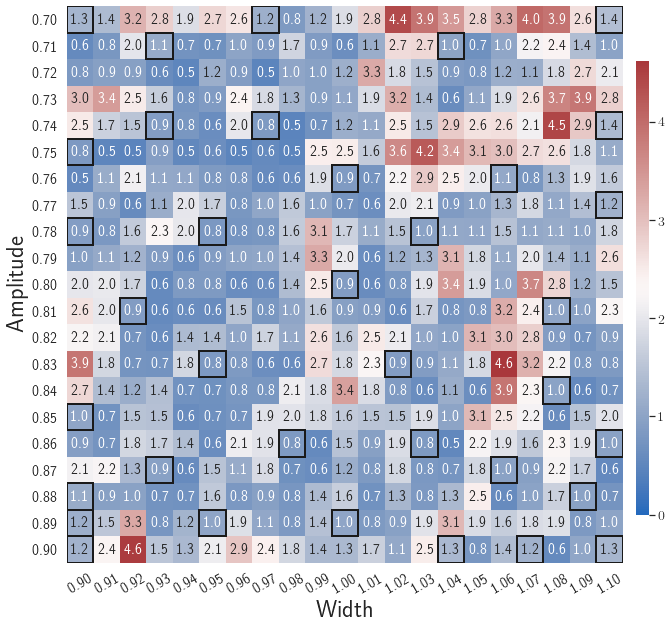

In [29]:
print(f'number of DIs: {len(idx_param)}')
max_err_heatmap(max_err, sindy_idx, idx_list, idx_param, dtype='float')

idx: 0, param: [0.7 0.9]
idx: 420, param: [0.7 1.1]
idx: 20, param: [0.9 0.9]
idx: 440, param: [0.9 1.1]
idx: 229, param: [0.89 1.  ]
idx: 216, param: [0.76 1.  ]
idx: 389, param: [0.81 1.08]
idx: 118, param: [0.83 0.95]
idx: 353, param: [0.87 1.06]
idx: 8, param: [0.78 0.9 ]
idx: 147, param: [0.7  0.97]
idx: 265, param: [0.83 1.02]
idx: 342, param: [0.76 1.06]
idx: 295, param: [0.71 1.04]
idx: 124, param: [0.89 0.95]
idx: 436, param: [0.86 1.1 ]
idx: 15, param: [0.85 0.9 ]
idx: 67, param: [0.74 0.93]
idx: 113, param: [0.78 0.95]
idx: 184, param: [0.86 0.98]
idx: 424, param: [0.74 1.1 ]
idx: 80, param: [0.87 0.93]
idx: 377, param: [0.9  1.07]
idx: 53, param: [0.81 0.92]
idx: 220, param: [0.8 1. ]
idx: 392, param: [0.84 1.08]
idx: 417, param: [0.88 1.09]
idx: 18, param: [0.88 0.9 ]
idx: 151, param: [0.74 0.97]
idx: 289, param: [0.86 1.03]
idx: 314, param: [0.9  1.04]
idx: 281, param: [0.78 1.03]
idx: 64, param: [0.71 0.93]
idx: 427, param: [0.77 1.1 ]
idx: 19, param: [0.89 0.9 ]
idx: 5,

/g/g92/he10/.conda/envs/tfvenv/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


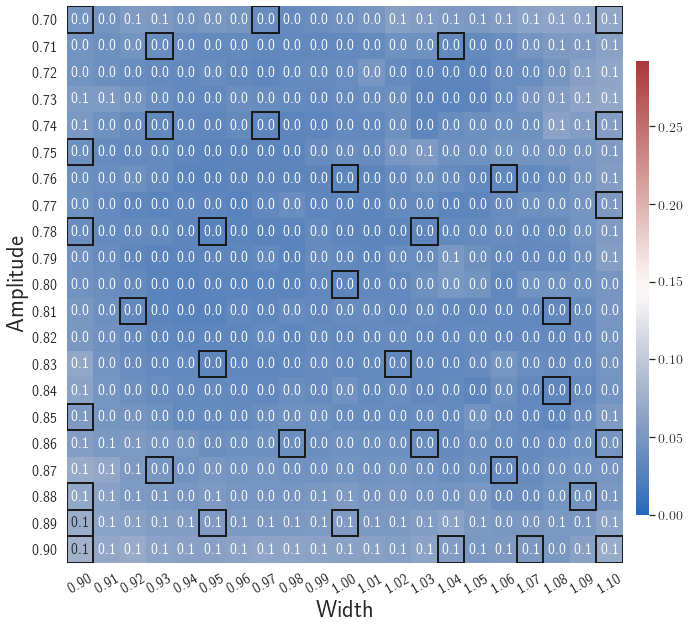

In [30]:
max_err_heatmap(res_norm, sindy_idx, idx_list, idx_param, label='Residual Norm', dtype='float', scale=10)